This notebook compares different weighting approaches for the SP500 - we're testing max sharpe weights (using the efficient frontier), min volatility, hierarchical risk parity, and equal weighted. We then take the top performing approach, and test in a walk-forward setting, i.e. defining the weights on in-sample, measure performance on out-of-sample.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import requests
from bs4 import BeautifulSoup
import yfinance as yf

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.hierarchical_portfolio import HRPOpt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_sp500_tickers():
    # Wikipedia URL for the S&P 500 list
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    # Send an HTTP request to the URL
    response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the table containing the S&P 500 tickers
        table = soup.find('table', {'class': 'wikitable'})
        
        # Extract tickers from the table
        tickers = []
        for row in table.find_all('tr')[1:]:  # Skip the header row
            ticker = row.find_all('td')[0].text.strip()
            tickers.append(ticker)
        
        return tickers
    else:
        # If the request was unsuccessful, print an error message
        print(f"Error: Unable to retrieve data from {url}")
        return None

# Get the list of S&P 500 tickers
sp500_tickers = get_sp500_tickers()

In [4]:
df = yf.download(' '.join(sp500_tickers), period='10y')['Adj Close']
df.dropna(axis=1, inplace=True)

[*********************100%%**********************]  503 of 503 completed


2 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')


In [6]:
raw_prices = pd.read_csv('./pairs/price_data.csv')
raw_prices = raw_prices.ffill().dropna(axis=1)
raw_prices.date = pd.to_datetime(raw_prices.date)
raw_prices.set_index('date', inplace=True)
raw_prices.drop(columns=['CIR', 'EMAN'], inplace=True) # price equals zero at few dates
universe = raw_prices.columns

In [22]:
df = raw_prices[raw_prices.columns[:100]].copy()

In [13]:
# Max Sharpe
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
weights_max_sharpe = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 35.6%
Annual volatility: 20.4%
Sharpe Ratio: 1.65


(0.356193957123444, 0.2035727035046898, 1.6514687447558454)

In [12]:
# Min Volatility
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
weights_min_vol = ef.min_volatility()
ef.portfolio_performance(verbose=True)

Expected annual return: 8.1%
Annual volatility: 12.2%
Sharpe Ratio: 0.50


(0.0813568813767547, 0.12158861502808964, 0.5046268629886105)

In [16]:
# Hiearchical Risk Parity
weights_hrp = HRPOpt(df.pct_change().replace(np.nan, 0)).optimize()

D:\vkotopoulos\vbt_env\lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218
 0.61833218 0.61833218 0.61833218 0.61833218 0.61833218 0.6183321

In [17]:
weighted_pf = {}
for asset in df.columns:
    weighted_pf[asset] = df[asset].pct_change() * weights_max_sharpe[asset]
weighted_pf = pd.DataFrame(weighted_pf)

In [18]:
weighted_pf_vol = {}
for asset in df.columns:
    weighted_pf_vol[asset] = df[asset].pct_change() * weights_min_vol[asset]
weighted_pf_vol = pd.DataFrame(weighted_pf_vol)

In [19]:
weighted_pf_hrp = {}
for asset in df.columns:
    weighted_pf_hrp[asset] = df[asset].pct_change() * weights_hrp[asset]
weighted_pf_hrp = pd.DataFrame(weighted_pf_hrp)

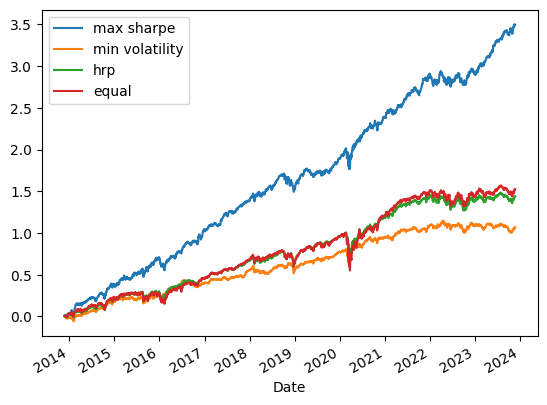

In [21]:
weighted_pf.sum(axis=1).cumsum().plot(label='max sharpe')
weighted_pf_vol.sum(axis=1).cumsum().plot(label='min volatility')
weighted_pf_hrp.sum(axis=1).cumsum().plot(label='hrp')
df.pct_change().mean(axis=1).cumsum().plot(label='equal')
plt.legend()

In [ ]:
# Question now becomes - how do they compare in a walk-forward setting (i.e. rebalancing?)
# Test with 3 different sets of lookback-trading : (2y, 6mo), (1y, 3mo), (6mo, 1mo)

In [35]:
in_days = 252*2
out_days = 126

wf_timestamps = range(in_days, len(df.index), out_days)

out_rets_max_sharpe = pd.Series()
out_rets_min_vol = pd.Series()
out_rets_hrp = pd.Series()

for i in tqdm(wf_timestamps):
    
    # Get in-sample and out-of-sample datasets
    in_data = df.loc[df.index[i-in_days]:df.index[i]]
    out_data = df.loc[df.index[i]:df.index[i+out_days]]
    
    # Compute in-sample weights

    # - max sharpe
    mu = expected_returns.mean_historical_return(in_data)
    S = risk_models.sample_cov(in_data)
    ef = EfficientFrontier(mu, S)
    weights_max_sharpe = ef.max_sharpe()

    # - min volatility
    mu = expected_returns.mean_historical_return(in_data)
    S = risk_models.sample_cov(in_data)
    ef = EfficientFrontier(mu, S)
    weights_min_vol = ef.min_volatility()

    # - hrp
    weights_hrp = HRPOpt(df.pct_change().replace(np.nan, 0)).optimize()
    
    # Get weighted out-of-sample portfolios
    
    w1 = {}
    w2 = {}
    w3 = {}
    for asset in df.columns:
        w1[asset] = out_data[asset].pct_change() * weights_max_sharpe[asset]
        w2[asset] = out_data[asset].pct_change() * weights_min_vol[asset]
        w3[asset] = out_data[asset].pct_change() * weights_hrp[asset]
    w1 = pd.DataFrame(w1)
    w2 = pd.DataFrame(w2)
    w3 = pd.DataFrame(w3)

    out_rets_max_sharpe = pd.concat([out_rets_max_sharpe, w1.sum(axis=1)])
    out_rets_min_vol = pd.concat([out_rets_min_vol, w2.sum(axis=1)])
    out_rets_hrp = pd.concat([out_rets_hrp, w3.sum(axis=1)])

  0%|                                                       | 0/16 [00:00<?, ?it/s]D:\vkotopoulos\vbt_env\lib\site-packages\pypfopt\hierarchical_portfolio.py:138: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573 0.61833573
 0.61833573 0.61833573 0.61833573 0.61833573 0.61

IndexError: index 2520 is out of bounds for axis 0 with size 2517

Text(0.5, 1.0, 'Walk Forward Test (2y in-sample, 6mo out-of-sample)')

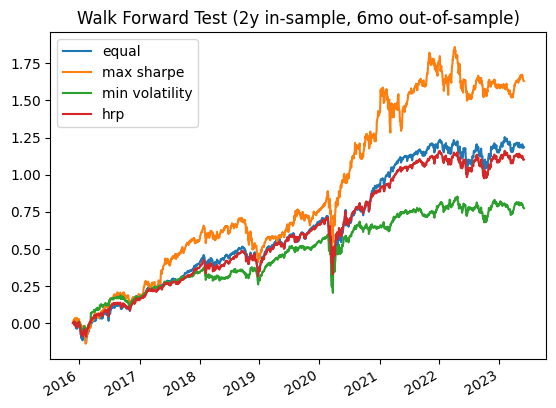

In [41]:
df.loc[out_rets.index].pct_change().mean(axis=1).cumsum().plot(label='equal')
out_rets_max_sharpe.cumsum().plot(label='max sharpe')
out_rets_min_vol.cumsum().plot(label='min volatility')
out_rets_hrp.cumsum().plot(label='hrp')
plt.legend()
plt.title('Walk Forward Test (2y in-sample, 6mo out-of-sample)')